## 2. Получение предсказаний на тестовой выборке и создание файла для kaggle.

Считаем данные из яндекс-диска

In [5]:
import os
import pandas as pd
path = r'/Users/ksushazinoveva/Downloads/kaggle_data' 
data = {}

Data = []
Target = []

i=0
for dir_entry in sorted(os.listdir(path)):
    dir_entry_path = os.path.join(path, dir_entry)
    if os.path.isfile(dir_entry_path):
        with open(dir_entry_path, 'r') as my_file:
            try:
                df = pd.read_csv(my_file, 'rb', delimiter=';', error_bad_lines=False)
                if df.shape[1] == 5:
                    Data.append(df)
                    Target.append(dir_entry_path.split("\\")[-1])
            except UnicodeDecodeError:
                pass

for dir_entry in sorted(os.listdir(path)):
    dir_entry_path = os.path.join(path, dir_entry)
    if os.path.isfile(dir_entry_path):
        with open(dir_entry_path, 'r') as my_file:
            try:
                df = pd.read_csv(my_file, 'rb', delimiter=',', error_bad_lines=False)
                if df.shape[1] == 5:
                    Data.append(df)
                    Target.append(dir_entry_path.split("\\")[-1])
            except UnicodeDecodeError:
                pass

In [10]:
Target

['/Users/ksushazinoveva/Downloads/kaggle_data/track_0.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_1.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_10.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_100.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_101.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_102.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_103.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_104.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_105.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_106.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_107.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_108.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_109.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_11.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_110.csv',
 '/Users/ksushazinoveva/Downloads/kaggle_data/track_111.csv',
 '/Users/ksush

Переведём типы движений в числа

In [2]:
classes = {'тояни' : 0, 'месте' : 0, 'тою' : 0, 'yat' : 0, 'окой' : 0, 'шаг' : 1, 'одьб' : 1, 'аг' : 1, 'go' : 1, 'ег' : 2, 'run' : 2, 'елоси' : 3, 'естн' : 4, 'одъ' : 4, 
           'втомо' : 5, 'ашин' : 5, 'авто' : 5, 'метро' : 6, 'лектро' : 7, 'амок' : 8, 'tair' : 4}

answers = {'стояние' : 0, 'ходьба' : 1, 'бег' : 2, 'велосипед' : 3, 'лестница' : 4, 
           'автомобиль' : 5, 'метро' : 6, 'электросамокат' : 7, 'самокат' : 8}

# стояние, ходьба, велосипед, лестница, бег, подъем, подъём, автомобиль, электросамокат, машина, метро

In [3]:
def get_action(name):
    for act in classes:
        if name.lower().find(act) != -1:
            return classes[act]
    return -1

Обработаем данные и извлечём признаки для создания модели

In [176]:
import pandas as pd
from matplotlib import pylab as plt
%pylab inline

def f(x):
    return (x[0] ** 2 + x[1] ** 2 + x[2] ** 2) ** 0.5
def time(x):
    return x[-7:]


def process_data(df, comma=True, cut=True, name = "", a=-1, b=-1):
    
# обрезаем начало и конец трека
    if a == -1:
        st = 1250
    else:
        st = a
            
    if b == -1:
        end = -1250
    else:
        end = b
        
    if cut == False:
        st = 0
        end = -1

    #print(name)
#     fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

# приводим данные с Iphone к нужному формату
    if comma is True:
        df = df.applymap(lambda x: str(x).replace(',','.'))
        
        try:
            df['gFx'] = df['gFx'].astype(float)
            df['gFy'] = df['gFy'].astype(float)
            df['gFz'] = df['gFz'].astype(float)
        except KeyError:
            return -1

# рисуем графики ускорений
#     if cut:
#         ax1.plot(df.iloc[st:end]['gFx'],c='g')
#         ax1.plot(df.iloc[st:end]['gFy'],c='r')
#         ax1.plot(df.iloc[st:end]['gFz'],c='b')
#     else:
#         ax1.plot(df['gFx'],c='g')
#         ax1.plot(df['gFy'],c='r')
#         ax1.plot(df['gFz'],c='b')
        
# вычисляем модуль (норму) ускорения и рисуем его
    Acc = (df.gFx[st:end] ** 2 + df.gFy[st:end] ** 2 + df.gFz[st:end] ** 2) ** 0.5
#     ax2.plot(Acc)
#     plt.show()

# можно различить многие действия по амплитуде ускорения
    amplitude = Acc.max() - Acc.min()
    #print(' АМПЛИТУДА:', Acc.max()-Acc.min())
    column_values = pd.Series( (df.gFx ** 2 + df.gFy ** 2 + df.gFz ** 2) ** 0.5 )
    df.insert(loc=0, column='AbsAcc', value=column_values)
    var = 0.0
    mid = df.AbsAcc.mean()
    for row in df.itertuples():
        var += (row.AbsAcc - mid) ** 2
    var /= (df.shape[0] - 1)
    return (amplitude, var)
    '''
    bike = 0
    if (double(df['gFy']).max() <= double(df['gFz']).min() + 0.1):
        bike = 1
    df['new_time'] = df['time'].apply(lambda x: x[-7:])
    if ('TgF' in df):
        mid = double(df['TgF']).mean()
        df['Diff'] = df['TgF'].apply(lambda x: abs(double(x) - mid))
    else:
        mid = double(df['gFTotal']).mean()
        df['Diff'] = df['gFTotal'].apply(lambda x: abs(double(x) - mid))
    cnt = 0
    i = int(df.shape[0]/2)
    try:
        start_time = double(df.iloc[i]['time'])
    except ValueError:
        start_time = double(df.iloc[i]['new_time'])
    cur_time = start_time
    while(cur_time - start_time < 0.1):
        if (double(df.iloc[i - 1]['Diff']) < double(df.iloc[i]['Diff']) < double(df.iloc[i + 1]['Diff'])):
            cnt += 1
        try:
            cur_time = double(df.iloc[i]['time'])
        except ValueError:
            cur_time = double(df.iloc[i]['new_time'])
        i += 1
    freq = cur_time - start_time
    return (amplitude, freq)
    #df['Total'] = df[['gFx', 'gFy', 'gFx']].apply(f, axis = 1)
    
    if ('TgF' in df):
        mid = double(df['TgF']).mean()
        df['Diff'] = df['TgF'].apply(lambda x: abs(double(x) - mid))
    else:
        mid = double(df['gFTotal']).mean()
        df['Diff'] = df['gFTotal'].apply(lambda x: abs(double(x) - mid))
    flag = 1
    flag1 = 1
    i = 1000
    min_diff = df['Diff'].min()
    df['new_time'] = df['time'].apply(time)
    while(flag):
        if (-0.0345 <= df.iloc[i]['Diff'] - min_diff <= 0.0345):
            if flag1:
                try:
                    start = double(df.iloc[i]['time'])
                except ValueError:
                    start = double(df.iloc[i]['new_time'])
                flag1 = 0
            else:
                try:
                    end = double(df.iloc[i]['time'])
                except ValueError:
                    end = double(df.iloc[i]['new_time'])
                flag = 0
        i += 1
    period = 2 * (end - start)
    print('ПЕРИОД: ', period)
    print('ЧАСТОТА:', 1/period)
    return (amplitude, 1/period)
    '''


Var = np.zeros(len(Data))
Ampl = np.zeros(len(Data)) 

for df, target in zip(Data,Target):
    track_num = int(target.split('_')[2].split('.')[0]) # важный момент, что треки не по нумерации идут!
    #print(process_data(df, name=target))
    Ampl[track_num] = process_data(df, name=target)[0]
    Var[track_num] = process_data(df, name=target)[1]

Populating the interactive namespace from numpy and matplotlib


In [100]:
def f(x):
    return (x[0] ** 2 + x[1] ** 2 + x[2] ** 2) ** 0.5
def time(x):
    return x[-7:]
print(time("2021-07-07 20:11:13.7230"))

13.7230


/Users/ksushazinoveva/Downloads/kaggle_data/track_104.csv
                          time    gFx    gFy    gFz             gFTotal
0     2021-07-07 20:11:13.7230  0.862  0.479 -0.018               0.986
1     2021-07-07 20:11:13.7240  0.862  0.479 -0.018               0.986
2     2021-07-07 20:11:13.7320  0.860  0.484 -0.070  0.9890000000000001
3     2021-07-07 20:11:13.7420  0.856  0.482 -0.132               0.991
4     2021-07-07 20:11:13.7520  0.844  0.470 -0.148               0.977
...                        ...    ...    ...    ...                 ...
2896  2021-07-07 20:11:42.7760  0.664  0.291 -0.552  0.9109999999999999
2897  2021-07-07 20:11:42.7860  0.679  0.308 -0.569               0.938
2898  2021-07-07 20:11:42.7960  0.706  0.319 -0.555               0.953
2899  2021-07-07 20:11:42.8060  0.744  0.335 -0.502               0.958
2900  2021-07-07 20:11:42.8160  0.732  0.345 -0.453               0.927

[2901 rows x 5 columns]


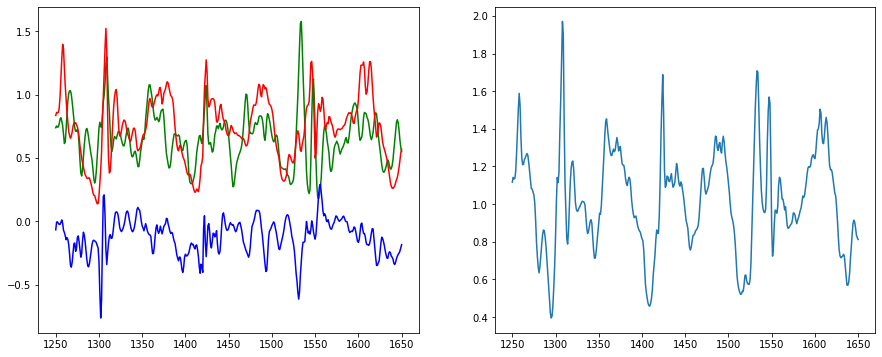

1.445999999999998


In [110]:
df = Data[7]
tg = Target[7]
print(tg)
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

df = df.applymap(lambda x: str(x).replace(',','.'))
        
try:
    df['gFx'] = df['gFx'].astype(float)
    df['gFy'] = df['gFy'].astype(float)
    df['gFz'] = df['gFz'].astype(float)
except KeyError:
    print(-1)

# рисуем графики ускорений
st = 1250
end = -1250
print(df)
ax1.plot(df.iloc[st:end]['gFx'],c='g')
ax1.plot(df.iloc[st:end]['gFy'],c='r')
ax1.plot(df.iloc[st:end]['gFz'],c='b')
Acc = (df.gFx[st:end] ** 2 + df.gFy[st:end] ** 2 + df.gFz[st:end] ** 2) ** 0.5
ax2.plot(Acc)
plt.show()
df['Total'] = df[['gFx', 'gFy', 'gFx']].apply(f, axis = 1)
mid = double(df['Total']).mean()
df['Diff'] = df['Total'].apply(lambda x: abs(double(x) - mid))
flag = 1
flag1 = 1
i = 1000
min_diff = df['Diff'].min()
df['new_time'] = df['time'].apply(time)
while(flag):
    if (-0.0345 <= df.iloc[i]['Diff'] - min_diff <= 0.0345):
        if flag1:
                try:
                    start = double(df.iloc[i]['time'])
                except ValueError:
                    start = double(df.iloc[i]['new_time'])
                flag1 = 0
        else:
                try:
                    end = double(df.iloc[i]['time'])
                except ValueError:
                    end = double(df.iloc[i]['new_time'])
                flag = 0
    i += 1
period = 2 * (end - start)
print(period)

Напишем функцию для получения предсказания (здесь используется только амплитуда, но в вашем итоговом решении будет больше признаков)

In [181]:
def get_prediction(ampl, var, num):
    if num >= 135:
        if ampl < 0.5:
            return 6
        if ampl < 1:
            return 5
        if ampl < 2:
            return 8
        return 7
    if ampl > 7:
        return 2 #бег
    if ampl < 0.5:
        return 0 #стояние
    if var < 0.1 and ampl > 2:
        return 3 #велик 
    if var < 0.13:
        return 4 #лестница
    return 1 #ходьба

In [182]:
len(Data), len(Ampl), len(Target), len(Var)

(146, 146, 146, 146)

In [187]:
Data[10]

,time,gFx,gFy,gFz,TgF
0,0.007488,"-0,0871","0,7511","0,6007","0,966"
1,0.008475,"-0,0802","0,7514","0,6004","0,965"
2,0.009329,"-0,0791","0,7525","0,6026","0,967"
3,0.009891,"-0,0827","0,7540","0,6059","0,971"
4,0.010458,"-0,0887","0,7555","0,6115","0,976"
...,...,...,...,...,...
4857,19.182554,"-0,1231","0,7750","0,8547","1,160"
4858,19.186618,"-0,1298","0,7833","0,8084","1,133"
4859,19.190180,"-0,1099","0,7776","0,7505","1,086"
4860,19.194527,"-0,0722","0,7642","0,6917","1,033"


In [184]:
Ampl_new = []

i=0
for elem in Ampl:
    if not (math.isnan(elem) or elem == -1):
        i+=1
        Ampl_new.append(elem)
    else:
        Ampl_new.append(2)
len(Ampl_new), i

(146, 140)

Создадим таблицу, содержащую номер трека и предсказание.

In [185]:
prediction = [get_prediction(a, v, n) for a, v, n in zip(Ampl, Var, [i for i in range(146)])]

Res = pd.DataFrame({'track_num' : np.arange(len(Data)), 'action' : prediction})
Res.tail(10)


,track_num,action
136,136,7
137,137,7
138,138,6
139,139,6
140,140,7
141,141,6
142,142,7
143,143,6
144,144,7
145,145,7


In [186]:
Res.to_csv("7_submit.csv", index=False)

In [188]:
Data[10]

,time,gFx,gFy,gFz,TgF
0,0.007488,"-0,0871","0,7511","0,6007","0,966"
1,0.008475,"-0,0802","0,7514","0,6004","0,965"
2,0.009329,"-0,0791","0,7525","0,6026","0,967"
3,0.009891,"-0,0827","0,7540","0,6059","0,971"
4,0.010458,"-0,0887","0,7555","0,6115","0,976"
...,...,...,...,...,...
4857,19.182554,"-0,1231","0,7750","0,8547","1,160"
4858,19.186618,"-0,1298","0,7833","0,8084","1,133"
4859,19.190180,"-0,1099","0,7776","0,7505","1,086"
4860,19.194527,"-0,0722","0,7642","0,6917","1,033"
